In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os #interacting with the operating system
import gc #optional garbage collector
import cv2
from glob import glob
import tensorflow as tf #end-to-end open source platform for machine learning
#keras and tensor flow modules used for the DL model and preprocessing
from keras import Sequential 
from keras.layers import *
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# matplotlib to plot images and visualizations 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

#train test split module from sklearn
from sklearn.model_selection import train_test_split

<ipython-input-1-6262527ba17f>:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path = 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification'
train_dir = os.path.join("D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/train/")
test_dir = os.path.join("D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/")
#not_train_path = os.path.join(path,"not_train/")
labels_path = os.path.join(path, "labels.csv")


In [25]:
train_dir

'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/train/'

In [26]:
labels_df = pd.read_csv(labels_path)
breed = labels_df['breed'].unique().tolist()

In [27]:
labels_df

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [28]:
dog_breeds = sorted(labels_df.breed.unique().tolist())
n_classes = len(dog_breeds)
print(n_classes)

120


In [29]:
class_to_num = dict(zip(dog_breeds, range(n_classes)))
class_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [74]:
(train_dir+labels_df.id+'.jpg')[0]

'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [75]:
cv2.imread((train_dir+labels_df.id+'.jpg')[0]).shape

(375, 500, 3)

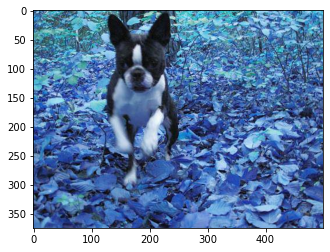

In [76]:
plt.imshow(cv2.imread((train_dir+labels_df.id+'.jpg')[0]))

In [77]:
labels_df['file_name'] = labels_df['id'].apply(lambda x: train_dir+f"{x}.jpg")

In [80]:
labels_df

id                     breed  \
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull   
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo   
2      001cdf01b096e06d78e9e5112d419397                  pekinese   
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick   
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever   
...                                 ...                       ...   
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi   
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont   
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale   
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher   
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever   

                                               file_name  
0      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
1      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
2      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
3      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
4      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
...                                                  ...  
10217  D:/Documentos/Master/temariomaster/TFM/dog-bre...  
10218  D:/Documentos/Master/temariomaster/TFM/dog-bre...  
10219  D:/Documentos/Master/temariomaster/TFM/dog-bre...  
10220  D:/Documentos/Master/temariomaster/TFM/dog-bre...  
10221  D:/Documentos/Master/temariomaster/TFM/dog-bre...  

[10222 rows x 3 columns]

### Loading the original data


In [ ]:
train_df_100_filtered_to_append = pd.read_csv('D:/Documentos/Master/temariomaster/TFM/Dog_Breed_Recognition_Competition_Datasets/train_df_100_filtrado_con_imgdir.csv')

In [ ]:
labels_df = labels_df.append(train_df_100_filtered_to_append)

In [79]:
labels_df['file_name'][0]

'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [83]:
labels_df['breed'] = labels_df.breed.map(class_to_num)

In [84]:
y = to_categorical(labels_df.breed)

In [85]:
labels_df

id  breed  \
0      000bec180eb18c7604dcecc8fe0dba07     19   
1      001513dfcb2ffafc82cccf4d8bbaba97     37   
2      001cdf01b096e06d78e9e5112d419397     85   
3      00214f311d5d2247d5dfe4fe24b2303d     15   
4      0021f9ceb3235effd7fcde7f7538ed62     49   
...                                 ...    ...   
10217  ffd25009d635cfd16e793503ac5edef0     18   
10218  ffd3f636f7f379c51ba3648a9ff8254f     35   
10219  ffe2ca6c940cddfee68fa3cc6c63213f      3   
10220  ffe5f6d8e2bff356e9482a80a6e29aac     75   
10221  fff43b07992508bc822f33d8ffd902ae     28   

                                               file_name  
0      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
1      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
2      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
3      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
4      D:/Documentos/Master/temariomaster/TFM/dog-bre...  
...                                                  ...  
10217  D:/Documentos/Master/temariomaster/TFM/dog-bre...  
10218  D:/Documentos/Master/temariomaster/TFM/dog-bre...  
10219  D:/Documentos/Master/temariomaster/TFM/dog-bre...  
10220  D:/Documentos/Master/temariomaster/TFM/dog-bre...  
10221  D:/Documentos/Master/temariomaster/TFM/dog-bre...  

[10222 rows x 3 columns]

In [86]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Feature extracction

In [ ]:
import tensorflow.keras as keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as restnet_preprocess
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from keras.applications.xception import Xception, preprocess_input as xception_preprocess
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocess
from keras.layers.merge import concatenate

In [3]:

input_shape = (331,331,3)
input_layer = Input(shape=input_shape) 

# First extractor inception_resnet
preprocesor_resnet = Lambda(restnet_preprocess)(input_layer)
inception_resnet = InceptionResNetV2(weights='imagenet',
                                     include_top = False,
                                     input_shape=input_shape,
                                     pooling='avg')(preprocesor_resnet)

# Second extractor inceptionV3
preprocesor_inception = Lambda(inception_preprocess)(input_layer)
inception_v3 = InceptionV3(weights='imagenet',
                                  include_top = False,
                                  input_shape=input_shape,
                                  pooling='avg')(preprocesor_inception)

# Third extractor Xception
preprocesor_xception = Lambda(xception_preprocess)(input_layer)
xception = Xception(weights='imagenet',
                              include_top = False,
                              input_shape=input_shape,
                              pooling='avg')(preprocesor_xception)

# Fouth extractor Xception
preprocesor_nasnet = Lambda(nasnet_preprocess)(input_layer)
nasnet = NASNetLarge(weights='imagenet',
                               include_top = False,
                               input_shape=input_shape,
                               pooling='avg')(preprocesor_nasnet)

merge = concatenate([inception_v3, xception, nasnet, inception_resnet])
model = keras.Model(inputs = input_layer, outputs=merge)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 331, 331, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

In [98]:
model.save('feature_extractor.h5')

C:\Users\franc\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [99]:
model.output.shape

TensorShape([None, 9664])

In [100]:
model.trainable_weights

[<tf.Variable 'conv2d_504/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[-4.59105551e-01, -4.14526574e-02, -3.62577499e-03,
           -9.87672508e-02, -3.37070860e-02,  4.79929037e-02,
            2.32542142e-01,  3.23927671e-01,  5.90160079e-02,
            9.47738215e-02,  4.24996056e-02,  1.26620471e-01,
            1.33215979e-01,  1.22741833e-01, -7.92686343e-02,
            2.08227970e-02, -1.99647829e-01, -3.02687973e-01,
           -2.10659921e-01, -3.52898419e-01, -5.58023095e-01,
            3.20223093e-01,  4.53596050e-03, -3.09266411e-02,
           -6.86957911e-02,  2.00968519e-01,  1.14542745e-01,
            2.40372881e-01,  1.52943470e-02,  5.96231259e-02,
           -5.85714653e-02,  8.78173351e-01],
          [ 3.16376328e-01, -4.78494260e-03, -6.84681814e-03,
            7.44503662e-02, -1.97458476e-01,  5.20143658e-02,
           -1.24460436e-01,  3.36123914e-01,  3.01678218e-02,
           -1.26477107e-01, -1.05597451e-01, -5.31241074e-02,
        

In [104]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [106]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 20
    X = np.zeros([data_size,9664], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,x_col='file_name', class_mode=None, batch_size=20, shuffle=False,
                                           target_size=(img_size[:2]), color_mode = 'rgb')
    i = 0
    try:
        for input_batch in tqdm(generator):
            input_batch = model.predict(input_batch)
            X[i * batch_size : (i + 1) * batch_size] = input_batch
            i += 1
            if i * batch_size >= data_size:
                break
    except:
        pass
    return X

## Training the model

In [111]:
X = feature_extractor(labels_df)

  0%|                                                                                          | 0/512 [00:00<?, ?it/s]

Found 10222 validated image filenames.


100%|█████████████████████████████████████████████████████████████████████████████▊| 511/512 [1:42:26<00:12, 12.03s/it]


In [112]:
X.shape

(10222, 9664)

In [113]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint(path, monitor='val_loss', mode='min', save_best_only=True)
lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience=3, min_lr=0.0001)
my_callback=[EarlyStop_callback,checkpoint]

In [115]:
dnn = keras.models.Sequential([
    InputLayer(X.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])
dnn.compile(optimizer='adam',
           loss='categorical_crossentropy',
           metrics=['accuracy'])

In [117]:
h = dnn.fit(X,y,
           batch_size=128,
           epochs=20,
           validation_split=0.1,
           callbacks=my_callback)

Epoch 1/20
72/72 [==============================] - 2s 24ms/step - loss: 3.8922 - accuracy: 0.5686 - val_loss: 2.8122 - val_accuracy: 0.9189
INFO:tensorflow:Assets written to: D:/Documentos/Master/temariomaster/TFM\dog-breed-identification\assets
Epoch 2/20
72/72 [==============================] - 2s 24ms/step - loss: 2.0855 - accuracy: 0.9079 - val_loss: 1.5548 - val_accuracy: 0.9247
INFO:tensorflow:Assets written to: D:/Documentos/Master/temariomaster/TFM\dog-breed-identification\assets
Epoch 3/20
72/72 [==============================] - 2s 22ms/step - loss: 1.2833 - accuracy: 0.9285 - val_loss: 1.0423 - val_accuracy: 0.9257
INFO:tensorflow:Assets written to: D:/Documentos/Master/temariomaster/TFM\dog-breed-identification\assets
Epoch 4/20
72/72 [==============================] - 2s 22ms/step - loss: 0.9289 - accuracy: 0.9437 - val_loss: 0.7953 - val_accuracy: 0.9277
INFO:tensorflow:Assets written to: D:/Documentos/Master/temariomaster/TFM\dog-breed-identification\assets
Epoch 5/20
7

In [13]:
#Ploting acc and loss

def plot_result(modelx):
    results = pd.DataFrame({'epochs':list(range(1,20+1)),'Training_acc':modelx.history.history['accuracy'],'Validation_acc':modelx.history.history['val_accuracy'],
                          'Training_loss':modelx.history.history['loss'],'Validation_loss':modelx.history.history['val_loss']})

    plt.figure(figsize=(12,5))
    sns.lineplot(x = 'epochs', y ='Training_acc', data = results, color='r' )
    sns.lineplot(x = 'epochs', y ='Validation_acc', data = results, color='blue' )
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.show()

    plt.figure(figsize=(12,5))
    sns.lineplot(x = 'epochs', y ='Training_loss', data = results, color='r' )
    sns.lineplot(x = 'epochs', y ='Validation_loss', data = results, color='blue' )
    plt.title('Training Loss vs Validation Loss')
    plt.show()

plot_result(dnn)

AttributeError: 'NoneType' object has no attribute 'history'

In [7]:
from keras.models import load_model
model_path = 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/model/modelbueno.h5'
dnn.save(model_path)

In [11]:
from tensorflow import keras
dnn = keras.models.load_model(model_path)

In [15]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_10 (Dropout)         (None, 9664)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               1159800   
Total params: 1,159,800
Trainable params: 1,159,800
Non-trainable params: 0
_________________________________________________________________


In [16]:
test_data = []
ids = []
for pic in os.listdir(test_dir):
    ids.append(pic.split('.')[0])
    test_data.append(test_dir+pic)

In [17]:
ids

['000621fb3cbb32d8935728e48679680e',
 '00102ee9d8eb90812350685311fe5890',
 '0012a730dfa437f5f3613fb75efcd4ce',
 '001510bc8570bbeee98c8d80c8a95ec1',
 '001a5f3114548acdefa3d4da05474c2e',
 '00225dcd3e4d2410dd53239f95c0352f',
 '002c2a3117c2193b4d26400ce431eebd',
 '002c58d413a521ae8d1a5daeb35fc803',
 '002f80396f1e3db687c5932d7978b196',
 '0036c6bcec6031be9e62a257b1c3c442',
 '0041940322116ae58c38130f5a6f71f9',
 '0042d6bf3e5f3700865886db32689436',
 '004476c96f575879af4af471af65cae8',
 '00485d47de966a9437ad3b33ac193b6f',
 '00496f65de6cc319145ce97bd6e90360',
 '004bf14426d1a830d459a9e0c0721309',
 '004c3721eb88358f462cdcec6b2380b7',
 '00559f56aab7e0a7749220f6aed65162',
 '005b281f1a4d6f29d527c9585e9bd33c',
 '005b6c6c76fefd6b458ef6fb6e54da6e',
 '006870b49353779b25eeb91fed43c31a',
 '0068f3a21b159ece126a28580cdad7a0',
 '0069b1cc4546fc98f84f981bf9a0696a',
 '0077bc3c63486ff09d3774d956af8f76',
 '00780e5d2bf4f7e4b5f96d08ddde669a',
 '007ed71136966728f5c0936e23c8286b',
 '0081831ceb49cd64212c32b884036b82',
 

In [18]:
test_data

['D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg',
 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/00102ee9d8eb90812350685311fe5890.jpg',
 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/test/002f80396f1e3db687c5932d7978b196.jpg',
 'D:/Docum

In [19]:
test_dataframe = pd.DataFrame({"file_name":test_data})

In [20]:
test_dataframe

file_name
0      D:/Documentos/Master/temariomaster/TFM/dog-bre...
1      D:/Documentos/Master/temariomaster/TFM/dog-bre...
2      D:/Documentos/Master/temariomaster/TFM/dog-bre...
3      D:/Documentos/Master/temariomaster/TFM/dog-bre...
4      D:/Documentos/Master/temariomaster/TFM/dog-bre...
...                                                  ...
10352  D:/Documentos/Master/temariomaster/TFM/dog-bre...
10353  D:/Documentos/Master/temariomaster/TFM/dog-bre...
10354  D:/Documentos/Master/temariomaster/TFM/dog-bre...
10355  D:/Documentos/Master/temariomaster/TFM/dog-bre...
10356  D:/Documentos/Master/temariomaster/TFM/dog-bre...

[10357 rows x 1 columns]

In [21]:
test_features = feature_extractor(test_dataframe)

  0%|                                                                                          | 0/518 [00:00<?, ?it/s]

Found 10357 validated image filenames.


100%|█████████████████████████████████████████████████████████████████████████████▊| 517/518 [3:09:45<00:22, 22.02s/it]


In [23]:
y_pred

array([[4.51569467e-05, 4.46658960e-05, 7.40467513e-05, ...,
        2.45847004e-05, 1.00557896e-04, 3.69508707e-05],
       [3.57897693e-06, 1.72198736e-06, 3.16584874e-06, ...,
        3.81770860e-06, 1.73797093e-06, 1.59968363e-06],
       [5.43038128e-04, 2.84002209e-03, 2.87502469e-03, ...,
        1.67716388e-03, 8.28505552e-04, 1.10675662e-03],
       ...,
       [6.65725238e-05, 5.89914016e-05, 1.89824612e-03, ...,
        1.17271207e-04, 5.06824217e-05, 5.25769865e-05],
       [7.78704009e-04, 7.42256350e-04, 4.20330180e-04, ...,
        5.03470597e-04, 2.34247258e-04, 1.35023217e-03],
       [4.05896426e-05, 1.62859782e-04, 1.35856346e-04, ...,
        7.90614402e-04, 5.76900129e-05, 3.09683892e-05]], dtype=float32)

In [22]:
y_pred = dnn.predict(test_features)

In [30]:
def get_key(val):
    for key, value in class_to_num.items():
        if val == value:
            return key
pred_codes = np.argmax(y_pred, axis=1)
predictions = []
for i in pred_codes:
    predictions.append(get_key(i))

In [31]:
test_dataframe['breed'] = predictions

In [32]:
test_dataframe

file_name             breed
0      D:/Documentos/Master/temariomaster/TFM/dog-bre...  japanese_spaniel
1      D:/Documentos/Master/temariomaster/TFM/dog-bre...           samoyed
2      D:/Documentos/Master/temariomaster/TFM/dog-bre...    english_setter
3      D:/Documentos/Master/temariomaster/TFM/dog-bre...               pug
4      D:/Documentos/Master/temariomaster/TFM/dog-bre...          shih-tzu
...                                                  ...               ...
10352  D:/Documentos/Master/temariomaster/TFM/dog-bre...   standard_poodle
10353  D:/Documentos/Master/temariomaster/TFM/dog-bre...        weimaraner
10354  D:/Documentos/Master/temariomaster/TFM/dog-bre...             dhole
10355  D:/Documentos/Master/temariomaster/TFM/dog-bre...             lhasa
10356  D:/Documentos/Master/temariomaster/TFM/dog-bre...   irish_wolfhound

[10357 rows x 2 columns]

In [33]:
test_dataframe.to_csv(r'D:/Documentos/Master/temariomaster/TFM/dog-breed-identification/model/predictions.csv', index = False)

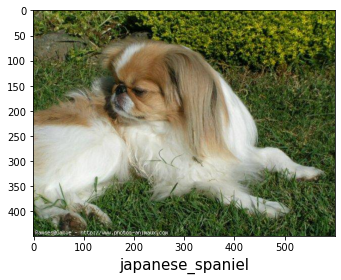

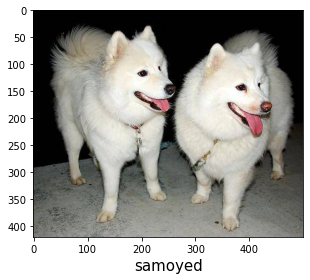

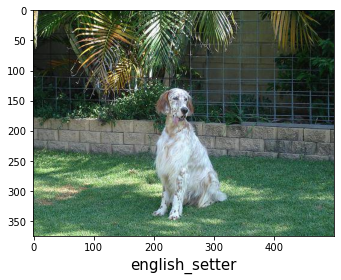

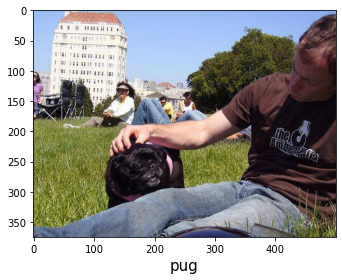

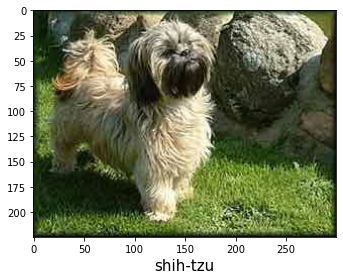

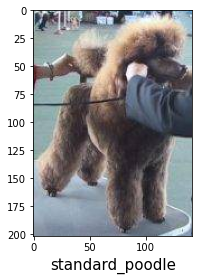

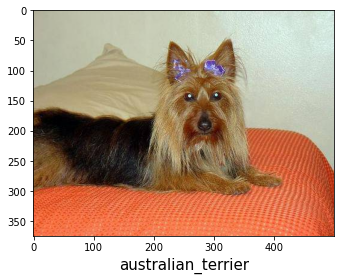

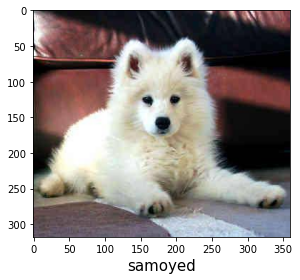

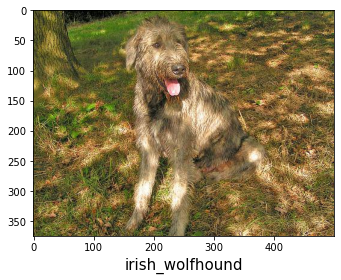

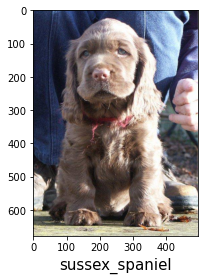

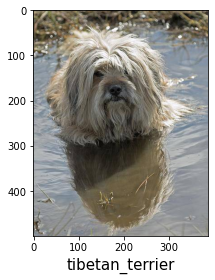

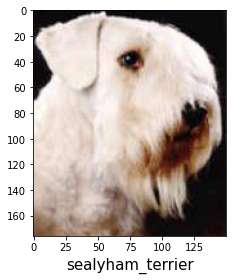

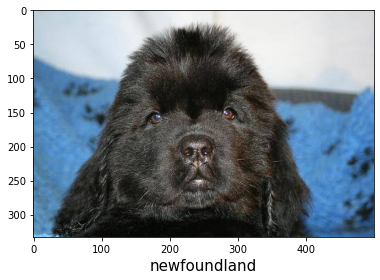

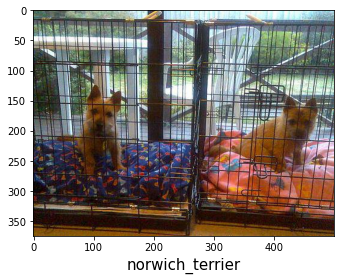

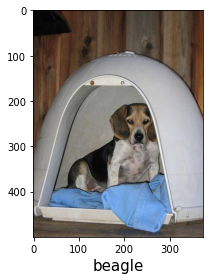

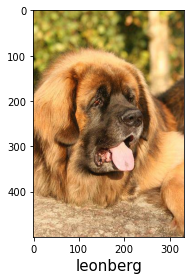

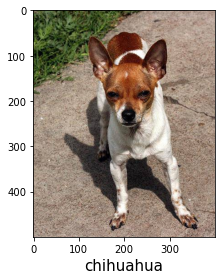

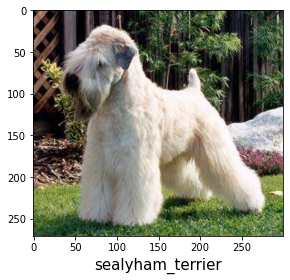

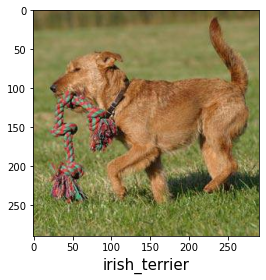

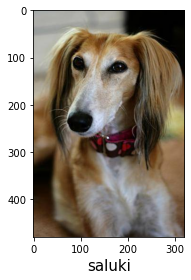

In [158]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
label = data['breed']
#img = cv2.imread(img)
    
def process(filename, label):
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(image)
    plt.xlabel(label, fontsize = (15))
    plt.tight_layout()
    plt.show

images = test_dataframe['file_name'][:20]
label = test_dataframe['breed'][:20]
i= 0
for file in images:
    process(file, label[i])
    i +=1

# Creating HDFS Cluster

### Initialize docker

-> git clone https://github.com/big-data-europe/docker-hadoop
-> docker-compose up -d
-> docker container ls
-> docker exec -it namenode /bin/bash

### Create Directories

-> hdfs dfs -ls /
-> hdfs dfs -mkdir -p /user/root
-> hdfs dfs -mkdir /user/root/input
-> hdfs dfs -mkdir /user/root/output


### Get Mapreduce Job

-> wget https://Frepo1.maven.org%2Fmaven2%2Forg%2Fapache%2Fhadoop%2Fhadoop-mapreduce-examples%2F2.7.1%2Fhadoop-mapreduce-examples-2.7.1-sources.jar
-> docker cp hadoop-mapreduce-examples-2.7.1-sources.jar namenode:/tmp/

### Save Results

In [ ]:
test_dataframe.to_csv(r'D:/Documentos/Master/temariomaster/TFM/docker-hadoop/predictions.csv', index = False)

 -> docker cp .\predictions.csv namenode:/tmp/
 -> docker exec -it namenode /bin/bash
 -> cd /tmp/
 -> ls
 Aqui están los archivos.


### Obtener los resultados desde hdfs

-> hdfs dfs -copyToLocal /user/root/results/part-r-00000 home
-> docker cp namenode:/home/part-r-00000 .\part-r-00000.csv